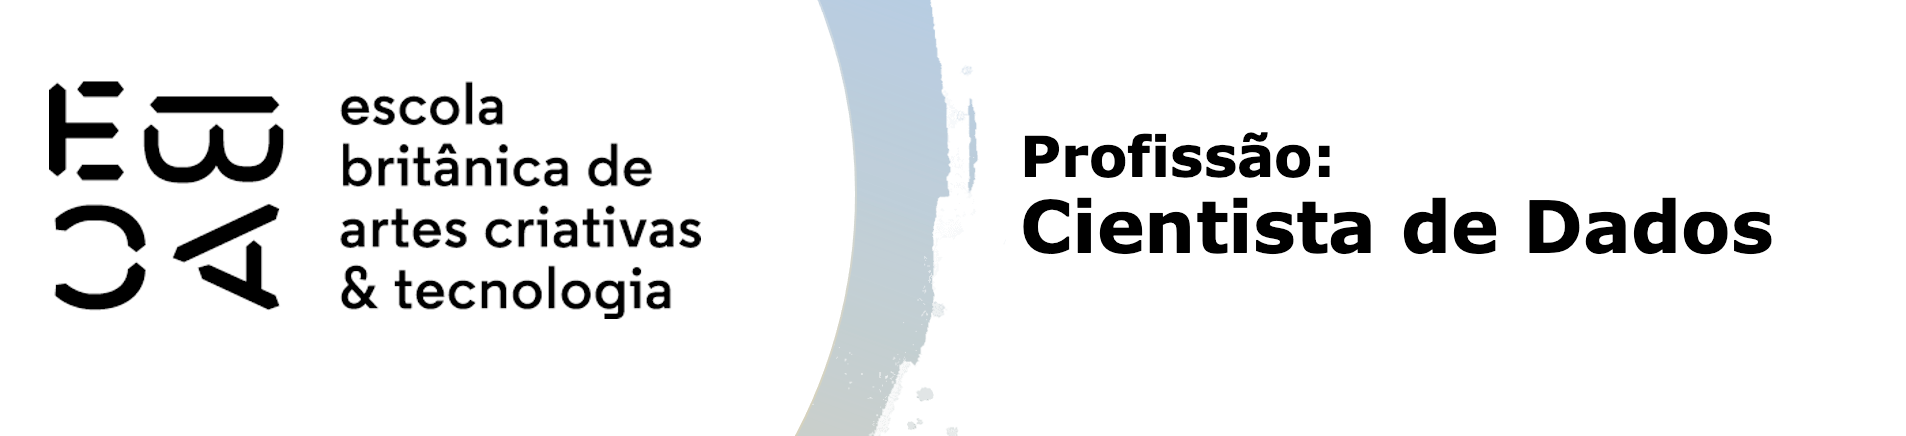

# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings;   warnings.filterwarnings("ignore")

In [2]:
df = pd.read_pickle('base_nfp.pkl')
df.set_index('Data Emissão', inplace=True)
df1 = df['2020-01-01':]
df1.reset_index(inplace=True)
print(df1.shape)
print(df1.info())
df1.head()

(86956, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86956 entries, 0 to 86955
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Data Emissão         86956 non-null  datetime64[ns]
 1   CNPJ emit.           86956 non-null  object        
 2   Emitente             86956 non-null  object        
 3   No.                  86956 non-null  int64         
 4   Valor NF             86956 non-null  float64       
 5   Data Registro        86956 non-null  datetime64[ns]
 6   Créditos             86956 non-null  float64       
 7   Situação do Crédito  86956 non-null  category      
 8   Ano                  86956 non-null  int64         
 9   Semestre             86956 non-null  int64         
 10  Retorno              86000 non-null  float64       
 11  flag_credito         86956 non-null  int64         
 12  categoria            86956 non-null  object        
dtypes: category(1), dat

,Data Emissão,CNPJ emit.,Emitente,No.,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,2020-01-01,05.234.750/0001-41,TX BURGER LTDA,77882,78.80,2020-08-01,0.0,A Calcular,2019,2,0.0,0,não definido
1,2020-01-01,47.508.411/1476-88,CIA BRASILEIRA DE DISTRIBUICAO,20087,22.71,2020-01-01,0.0,A Calcular,2019,2,0.0,0,Mercado
2,2020-01-01,09.060.964/0108-39,PIMENTA VERDE ALIMENTOS LTDA,82366,35.90,2020-08-01,0.0,A Calcular,2019,2,0.0,0,Alimentos
3,2020-01-01,61.412.110/0307-39,DROGARIA SAO PAULO S A,234178,21.77,2020-08-01,0.0,A Calcular,2019,2,0.0,0,Farmácia
4,2020-01-01,46.952.032/0001-98,PANIFICADORA E CONFEITARIA QUELUZ LTDA,3305,80.95,2020-08-01,0.0,A Calcular,2019,2,0.0,0,Restaurantes


## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [3]:
# Variáveis temporais
df1['Dia_de_semana'] = df1['Data Emissão'].dt.day_name()
df1['Fim_de_semana'] = ((df1['Data Emissão'].dt.dayofweek) // 5 == 1).astype(float)
df1['Dia_mes'] = df1['Data Emissão'].dt.day
df1['Mes'] = df1['Data Emissão'].dt.month
df1['Trimestre'] = df1['Data Emissão'].dt.quarter
df1['Ano'] = df1['Data Emissão'].dt.year
df1.head(3)

,Data Emissão,CNPJ emit.,Emitente,No.,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria,Dia_de_semana,Fim_de_semana,Dia_mes,Mes,Trimestre
0,2020-01-01,05.234.750/0001-41,TX BURGER LTDA,77882,78.80,2020-08-01,0.0,A Calcular,2020,2,0.0,0,não definido,Wednesday,0.0,1,1,1
1,2020-01-01,47.508.411/1476-88,CIA BRASILEIRA DE DISTRIBUICAO,20087,22.71,2020-01-01,0.0,A Calcular,2020,2,0.0,0,Mercado,Wednesday,0.0,1,1,1
2,2020-01-01,09.060.964/0108-39,PIMENTA VERDE ALIMENTOS LTDA,82366,35.90,2020-08-01,0.0,A Calcular,2020,2,0.0,0,Alimentos,Wednesday,0.0,1,1,1


In [4]:
# Categorizações do Valor NF 
categorias = [5, 10, 20, 50]
for categoria in categorias:
    titulo = f'{categoria} Categorias'
    df1[titulo] = pd.qcut(df1['Valor NF'], categoria, labels=False)
df1.head(3)

,Data Emissão,CNPJ emit.,Emitente,No.,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,...,categoria,Dia_de_semana,Fim_de_semana,Dia_mes,Mes,Trimestre,5 Categorias,10 Categorias,20 Categorias,50 Categorias
0,2020-01-01,05.234.750/0001-41,TX BURGER LTDA,77882,78.80,2020-08-01,0.0,A Calcular,2020,2,...,não definido,Wednesday,0.0,1,1,1,2,5,11,27
1,2020-01-01,47.508.411/1476-88,CIA BRASILEIRA DE DISTRIBUICAO,20087,22.71,2020-01-01,0.0,A Calcular,2020,2,...,Mercado,Wednesday,0.0,1,1,1,0,1,3,9
2,2020-01-01,09.060.964/0108-39,PIMENTA VERDE ALIMENTOS LTDA,82366,35.90,2020-08-01,0.0,A Calcular,2020,2,...,Alimentos,Wednesday,0.0,1,1,1,1,3,6,15


## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [5]:
#Definindo o metadados
df2 = df1.copy()
df2.drop(columns=['Data Emissão',
    'CNPJ emit.',
    'Emitente',
    'No.',
    'Valor NF',
    'Data Registro',
    'Créditos',
    'Situação do Crédito',
    'Retorno'], inplace=True)
metadados = pd.DataFrame({'dtype':df2.dtypes})
metadados

,dtype
Ano,int32
Semestre,int64
flag_credito,int64
categoria,object
Dia_de_semana,object
Fim_de_semana,float64
Dia_mes,int32
Mes,int32
Trimestre,int32
5 Categorias,int64


In [6]:
#Atribuindo papéis
metadados['papel'] = 'covariavel'
metadados.loc['flag_credito','papel'] = 'resposta'
metadados['nunique'] = df2.nunique()
metadados

,dtype,papel,nunique
Ano,int32,covariavel,2
Semestre,int64,covariavel,2
flag_credito,int64,resposta,2
categoria,object,covariavel,9
Dia_de_semana,object,covariavel,7
Fim_de_semana,float64,covariavel,2
Dia_mes,int32,covariavel,31
Mes,int32,covariavel,12
Trimestre,int32,covariavel,4
5 Categorias,int64,covariavel,5


In [7]:
# Função IV
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

# Populando o metadados
for var in metadados[metadados.papel == 'covariavel'].index:
    if pd.api.types.is_numeric_dtype(df2[var]):
        if metadados.loc[var, 'nunique'] > 50:
            metadados.loc[var, 'IV'] = IV(pd.qcut(df2[var], 5, duplicates='drop'), df2.flag_credito)
        else:
            metadados.loc[var, 'IV'] = IV(df2[var], df2.flag_credito)
    else:
        metadados.loc[var, 'IV'] = IV(df2[var], df2.flag_credito)

In [8]:
# Interpretação dos valores de IV
metadados.loc[metadados['IV'] < 0.02, 'poder_preditivo'] = 'Irrelevante'
metadados.loc[(metadados['IV'] >= 0.02) & (metadados['IV'] <= 0.1), 'poder_preditivo'] = 'Fraco'
metadados.loc[(metadados['IV'] > 0.1) & (metadados['IV'] <= 0.3), 'poder_preditivo'] = 'Médio'
metadados.loc[(metadados['IV'] > 0.3) & (metadados['IV'] <= 0.5), 'poder_preditivo'] = 'Forte'
metadados.loc[metadados['IV'] > 0.5, 'poder_preditivo'] = 'Atenção, muito alto'
metadados

,dtype,papel,nunique,IV,poder_preditivo
Ano,int32,covariavel,2,0.003195,Irrelevante
Semestre,int64,covariavel,2,0.004874,Irrelevante
flag_credito,int64,resposta,2,NaN,nan
categoria,object,covariavel,9,0.278826,Médio
Dia_de_semana,object,covariavel,7,0.005878,Irrelevante
Fim_de_semana,float64,covariavel,2,0.004599,Irrelevante
Dia_mes,int32,covariavel,31,0.015128,Irrelevante
Mes,int32,covariavel,12,0.009098,Irrelevante
Trimestre,int32,covariavel,4,0.003554,Irrelevante
5 Categorias,int64,covariavel,5,0.038990,Fraco


## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

**Conclusão:** A variável ``categoria`` possui poder preditivo médio. As demais variáveis possuem poder preditivo praticamente irrelevante ou fraco, com exceção da categorização da variável ``Valor NF`` por 50 categorias, que apresentou poder preditivo médio.

## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

In [9]:
# Quantidade de notas registradas na base por período
df3 = df2.groupby(['Trimestre', 'flag_credito']).size().unstack(fill_value=0)
df3['N'] = df3.sum(axis=1)
df3.head()
df3

flag_credito,0,1,N
Trimestre,,,
1,11521,9146,20667
2,12167,8231,20398
3,12618,9720,22338
4,13332,10221,23553


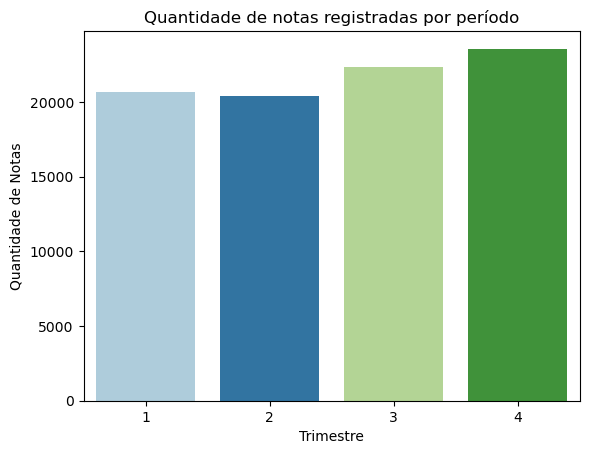

In [10]:
# Quantidade de notas registradas na base por período
sns.barplot(data=df3, x='Trimestre', y='N', palette='Paired')
plt.title('Quantidade de notas registradas por período')
plt.xlabel('Trimestre')
plt.ylabel('Quantidade de Notas')
plt.show()

In [11]:
# Quantidade de notas por categoria e por período
df4 = df2.groupby(['Trimestre', 'categoria', 'flag_credito']).size().unstack(fill_value=0)
df4['N'] = df4.sum(axis=1)
df4['tx_evento'] = df4[1] / df4['N']
df4.reset_index(inplace=False)
df4

flag_credito               0     1     N  tx_evento
Trimestre categoria                                
1         Alimentos      374   908  1282   0.708268
          Auto posto     118    34   152   0.223684
          Construção    2043  1811  3854   0.469901
          Farmácia      1794   638  2432   0.262336
          Mercado       3456  3271  6727   0.486249
          Restaurantes   164   590   754   0.782493
          Varejo         777   172   949   0.181243
          Vestuário      314   115   429   0.268065
          não definido  2481  1607  4088   0.393102
2         Alimentos      431   736  1167   0.630677
          Auto posto      88    28   116   0.241379
          Construção    2126  1680  3806   0.441408
          Farmácia      1675   817  2492   0.327849
          Mercado       3453  3102  6555   0.473227
          Restaurantes   127   299   426   0.701878
          Varejo        1118   148  1266   0.116904
          Vestuário      347    79   426   0.185446
          não definido  2802  1342  4144   0.323842
3         Alimentos      378   849  1227   0.691932
          Auto posto      95    41   136   0.301471
          Construção    2075  2004  4079   0.491297
          Farmácia      1626   943  2569   0.367069
          Mercado       3723  3370  7093   0.475116
          Restaurantes   116   397   513   0.773879
          Varejo        1156   184  1340   0.137313
          Vestuário      337   119   456   0.260965
          não definido  3112  1813  4925   0.368122
4         Alimentos      425   949  1374   0.690684
          Auto posto     104    32   136   0.235294
          Construção    2280  2028  4308   0.470752
          Farmácia      1512  1184  2696   0.439169
          Mercado       3749  3434  7183   0.478073
          Restaurantes   146   340   486   0.699588
          Varejo        1314   197  1511   0.130377
          Vestuário      479   130   609   0.213465
          não definido  3323  1927  5250   0.367048

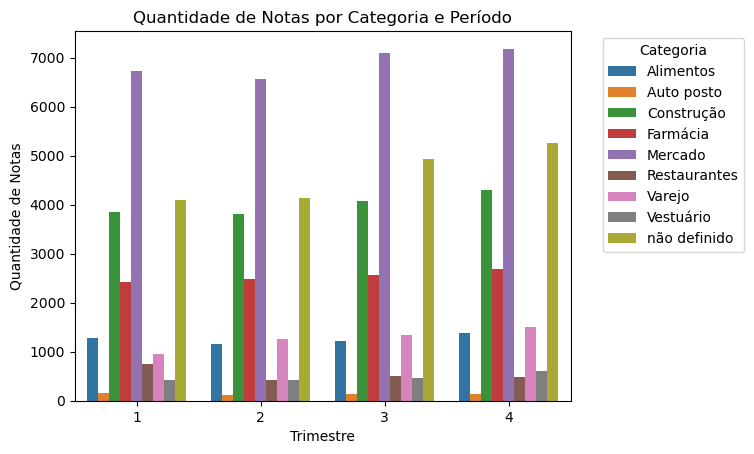

In [12]:
# Quantidade de notas por categoria e por período
sns.barplot(data=df4, x='Trimestre', y='N', hue='categoria')

plt.title('Quantidade de Notas por Categoria e Período')
plt.xlabel('Trimestre')
plt.ylabel('Quantidade de Notas')
plt.legend(title='Categoria', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

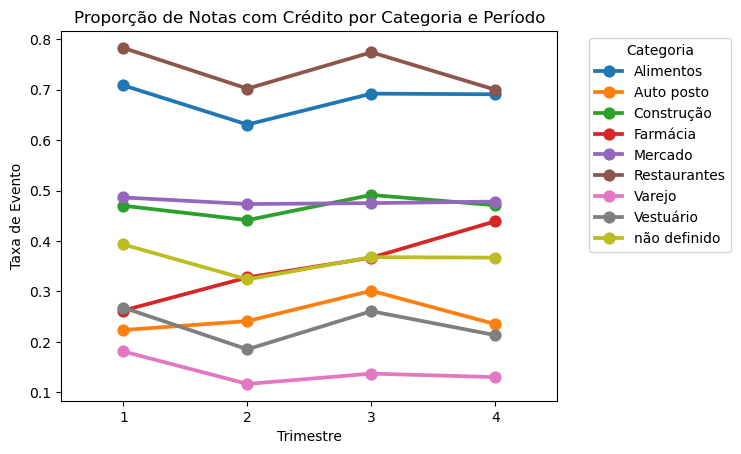

In [13]:
# Proporção de notas com crédito por categoria e período
sns.pointplot(data=df4, x='Trimestre', y='tx_evento', hue='categoria')
plt.title('Proporção de Notas com Crédito por Categoria e Período')
plt.xlabel('Trimestre')
plt.ylabel('Taxa de Evento')
plt.legend(title='Categoria', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

In [14]:
rotulo_ev, rotulo_nev = (1, 0)
df4['pct_evento'] = df4[rotulo_ev]/df4[rotulo_ev].groupby(level=0).sum()
df4['pct_nao_evento'] = df4[rotulo_nev]/df4[rotulo_nev].groupby(level=0).sum()
df4['WOE'] = np.log(df4.pct_evento/df4.pct_nao_evento)
df4['IV'] = ((df4.pct_evento - df4.pct_nao_evento)*df4.WOE)
df4.loc[df4['IV'] < 0.02, 'poder_preditivo'] = 'Irrelevante'
df4.loc[(df4['IV'] >= 0.02) & (df4['IV'] <= 0.1), 'poder_preditivo'] = 'Fraco'
df4.loc[(df4['IV'] > 0.1) & (df4['IV'] <= 0.3), 'poder_preditivo'] = 'Médio'
df4.loc[(df4['IV'] > 0.3) & (df4['IV'] <= 0.5), 'poder_preditivo'] = 'Forte'
df4.loc[df4['IV'] > 0.5, 'poder_preditivo'] = 'Atenção, muito alto'
df4

flag_credito               0     1     N  tx_evento  pct_evento  \
Trimestre categoria                                               
1         Alimentos      374   908  1282   0.708268    0.099278   
          Auto posto     118    34   152   0.223684    0.003717   
          Construção    2043  1811  3854   0.469901    0.198010   
          Farmácia      1794   638  2432   0.262336    0.069757   
          Mercado       3456  3271  6727   0.486249    0.357643   
          Restaurantes   164   590   754   0.782493    0.064509   
          Varejo         777   172   949   0.181243    0.018806   
          Vestuário      314   115   429   0.268065    0.012574   
          não definido  2481  1607  4088   0.393102    0.175705   
2         Alimentos      431   736  1167   0.630677    0.089418   
          Auto posto      88    28   116   0.241379    0.003402   
          Construção    2126  1680  3806   0.441408    0.204106   
          Farmácia      1675   817  2492   0.327849    0.099259   
          Mercado       3453  3102  6555   0.473227    0.376868   
          Restaurantes   127   299   426   0.701878    0.036326   
          Varejo        1118   148  1266   0.116904    0.017981   
          Vestuário      347    79   426   0.185446    0.009598   
          não definido  2802  1342  4144   0.323842    0.163042   
3         Alimentos      378   849  1227   0.691932    0.087346   
          Auto posto      95    41   136   0.301471    0.004218   
          Construção    2075  2004  4079   0.491297    0.206173   
          Farmácia      1626   943  2569   0.367069    0.097016   
          Mercado       3723  3370  7093   0.475116    0.346708   
          Restaurantes   116   397   513   0.773879    0.040844   
          Varejo        1156   184  1340   0.137313    0.018930   
          Vestuário      337   119   456   0.260965    0.012243   
          não definido  3112  1813  4925   0.368122    0.186523   
4         Alimentos      425   949  1374   0.690684    0.092848   
          Auto posto     104    32   136   0.235294    0.003131   
          Construção    2280  2028  4308   0.470752    0.198415   
          Farmácia      1512  1184  2696   0.439169    0.115840   
          Mercado       3749  3434  7183   0.478073    0.335975   
          Restaurantes   146   340   486   0.699588    0.033265   
          Varejo        1314   197  1511   0.130377    0.019274   
          Vestuário      479   130   609   0.213465    0.012719   
          não definido  3323  1927  5250   0.367048    0.188533   

flag_credito            pct_nao_evento       WOE        IV poder_preditivo  
Trimestre categoria                                                         
1         Alimentos           0.032462  1.117843  0.074690           Fraco  
          Auto posto          0.010242 -1.013469  0.006613     Irrelevante  
          Construção          0.177328  0.110315  0.002281     Irrelevante  
          Farmácia            0.155716 -0.803010  0.069025           Fraco  
          Mercado             0.299974  0.175839  0.010140     Irrelevante  
          Restaurantes        0.014235  1.511111  0.075970           Fraco  
          Varejo              0.067442 -1.277091  0.062113           Fraco  
          Vestuário           0.027255 -0.773606  0.011357     Irrelevante  
          não definido        0.215346 -0.203438  0.008064     Irrelevante  
2         Alimentos           0.035424  0.925942  0.049996           Fraco  
          Auto posto          0.007233 -0.754312  0.002890     Irrelevante  
          Construção          0.174735  0.155371  0.004563     Irrelevante  
          Farmácia            0.137667 -0.327109  0.012564     Irrelevante  
          Mercado             0.283800  0.283624  0.026396           Fraco  
          Restaurantes        0.010438  1.247076  0.032284           Fraco  
          Varejo              0.091888 -1.631265  0.120562           Médio  
          Vestuário           0.028520 -1.089057  0.020607         

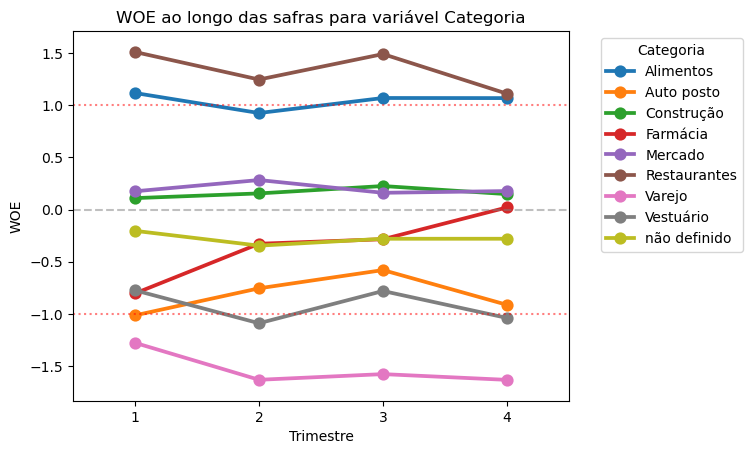

In [15]:
fig, ax = plt.subplots()
variavel='categoria'

# Comando principal do gráfico
sns.pointplot(data=df4.reset_index(), y = 'WOE', x = 'Trimestre', hue=variavel, ax=ax);

#limites do gráfico - mostrando 1 e -1 para ter referência
ymax = max(1.2, max(df4.WOE))
ymin = min(-1.2, min(df4.WOE))
ax.set_ylim(df4['WOE'].min() - 0.2, df4['WOE'].max() + 0.2)

# Linhas de referência
ax.axhline(1, linestyle=':'  , color='red', alpha=.5)
ax.axhline(0, linestyle='--' , color='grey', alpha=.5)
ax.axhline(-1, linestyle=':' , color='red', alpha=.5)

# Títulos
ax.set_title(f'WOE ao longo das safras para variável {variavel.capitalize()}')
ax.set_xlabel('Trimestre')
plt.legend(title='Categoria', bbox_to_anchor=(1.05, 1), loc='upper left');

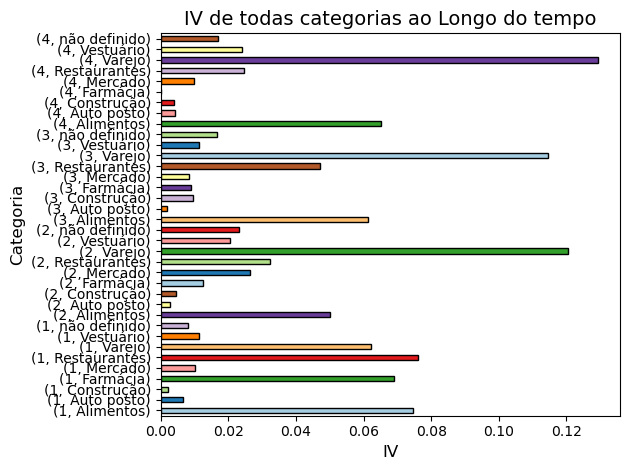

In [16]:
palette = sns.color_palette("Paired", len(df4['IV']))

ax = df4['IV'].plot(kind='barh', color=palette, edgecolor='black')

plt.xlabel('IV', fontsize=12)
plt.ylabel('Categoria', fontsize=12)
plt.title('IV de todas categorias ao Longo do tempo', fontsize=14)

plt.tight_layout()

plt.show()

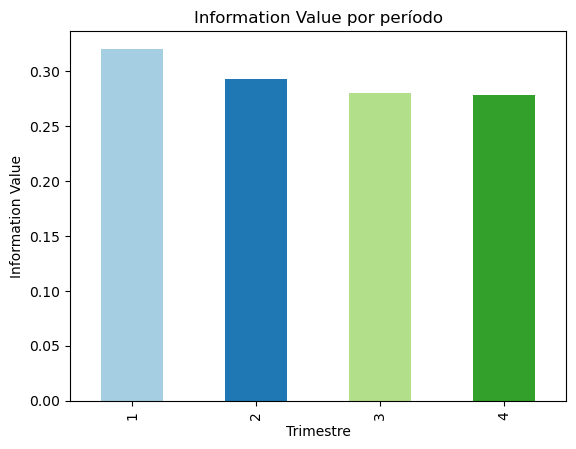

In [17]:
iv_categoria = ((df4.pct_evento - df4.pct_nao_evento)*df4.WOE).groupby(level=0).sum();
palette = sns.color_palette("Paired", len(iv_categoria))

iv_categoria.plot.bar(color=palette)
plt.title('Information Value por período')
plt.xlabel('Trimestre')
plt.ylabel('Information Value')
plt.show()

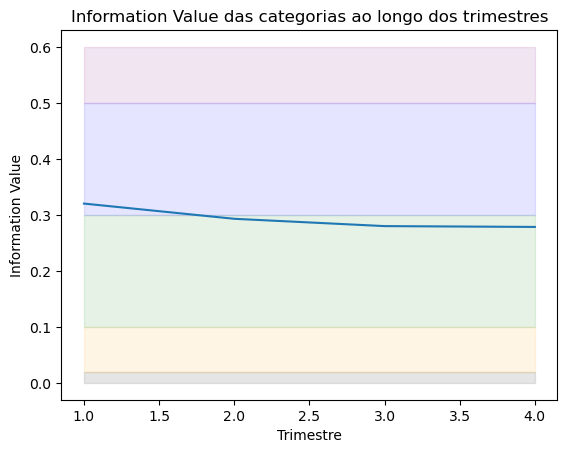

In [18]:
def plot_iv(IV):
    fig, ax = plt.subplots()
    x = IV.index
    a = [.02]*len(IV.index)
    b = [.1]*len(IV.index)
    c = [.3]*len(IV.index)
    d = [.5]*len(IV.index)
    e = [.6]*len(IV.index)

    ax.fill_between(IV.index, a, color='grey', alpha=.2)
    ax.fill_between(IV.index, a, b, color='orange', alpha=.1)
    ax.fill_between(IV.index, b, c, color='green', alpha=.1)
    ax.fill_between(IV.index, c, d, color='blue', alpha=.1)
    ax.fill_between(IV.index, d, e, color='purple', alpha=.1)
    ax.plot(IV)

    ax.set_title("Information Value das categorias ao longo dos trimestres")
    ax.set_ylabel("Information Value")
    ax.set_xlabel("Trimestre")
    
plot_iv(iv_categoria)

## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

**Conclusões:** 
- ``Restaurantes`` e ``Alimentos`` são as categorias consistentemente apresentaram uma alta proporção de notas com retorno positivo ao longo dos trimestres;
- É Interessante observar que a base é de 2020, periodo da pandemia, e notamos que a variável ``Farmácia`` foi a que apresentou o maior crescimento dentre todas;
- Confirmando a conclusão do exercício anterior, ``Varejo`` apresenta WOE negativo, mostrando que a maioria das notas tende a não gerar crédito positivo. Mesmo que possa haver um grande número de notas nessa categoria, o potencial de retorno é baixo. Outra variável com comportamento semelhante é ``Auto Posto``, o que pode ser explicado pelo fato de comercializarem produtos que não geram crédito, como cigarros e bebidas alcoólicas.